# Creacion del seguidor de fase

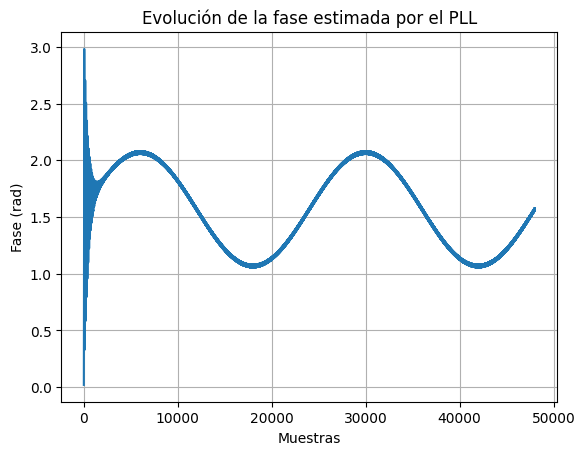

In [ ]:
import numpy as np


def pll_track_phase(signal, fs, fc, Kp=0.01, Ki=0.01):
    """
    PLL muy simple para estimar la fase de una portadora conocida fc.
    Devuelve:
      - phase_hist: evolución de la fase estimada por muestra
      - phase_final: fase final estimada
    """

    N = len(signal)
    phase = 0.0         # fase inicial
    integ = 0.0         # término integral
    phase_hist = np.zeros(N)
    w0 = 2 * np.pi * fc / fs  # frecuencia normalizada

    for n in range(N):
        # oscilador local
        lo = np.cos(w0 * n + phase)

        # detector de fase simple: error ~ producto señal * lo
        error = signal[n] * lo

        # lazo PI
        integ += Ki * error
        phase += Kp * error + integ

        phase_hist[n] = phase

    phase_final = phase_hist[-1]
    return phase_hist, phase_final

# prueba de la función pll_track_phase
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    fs = 48000
    fc = 3000
    t = np.arange(0, 1.0, 1/fs)
    # señal portadora con fase variable
    signal = np.cos(2 * np.pi * fc * t + 0.5 * np.sin(2 * np.pi * 2 * t))

    phase_hist, phase_final = pll_track_phase(signal, fs, fc)

    plt.figure()
    plt.plot(phase_hist)
    plt.title("Evolución de la fase estimada por el PLL")
    plt.xlabel("Muestras")
    plt.ylabel("Fase (rad)")
    plt.grid()
    plt.show()

# creacion del Coseno levantado

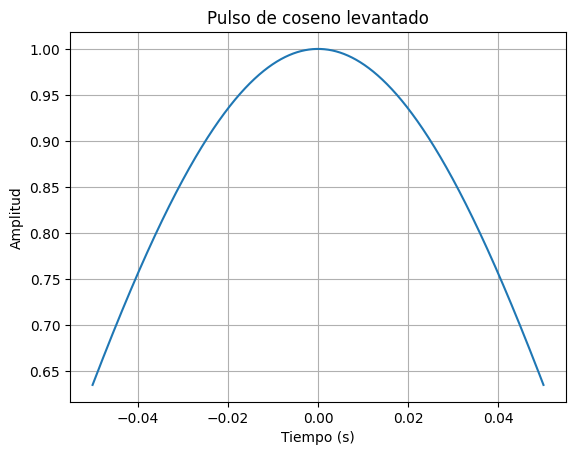

In [70]:
import sounddevice as sd
import matplotlib.pyplot as plt
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N
 # Prueba de la función raised_cosine_pulse
if __name__ == "__main__":
    Tb = 0.1
    fs = 48000
    beta = 0.1

    pulse, N = raised_cosine_pulse(Tb, fs, beta)

    t = np.linspace(-Tb/2, Tb/2, N)
    plt.figure()
    plt.plot(t, pulse)
    plt.title("Pulso de coseno levantado")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

# Funcion de modulacion 8psk

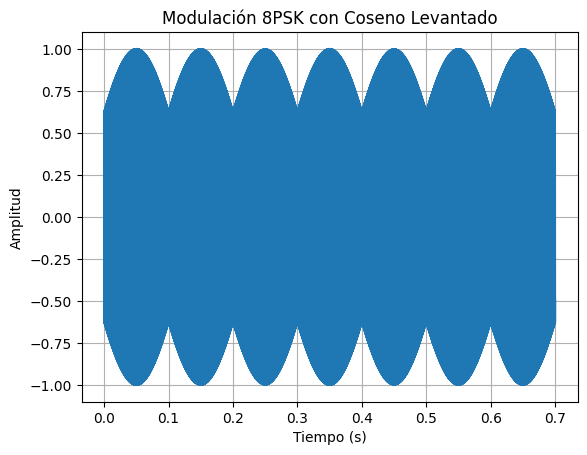

Bits originales:  000001011110101100111
Bits recibidos:   000001011110101100111


In [76]:

def modulate_8psk(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 8PSK + Raised Cosine.

    bits : str       Cadena de bits (múltiplo de 3)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 3 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 3 para 8PSK.")

    # --- Mapeo Gray 3 bits → ángulo ---
    # 8-PSK de amplitud CONSTANTE = 1
    mapping = {
        "000": 0,
        "001": np.pi/4,
        "011": np.pi/2,
        "010": 3*np.pi/4,
        "110": np.pi,
        "111": 5*np.pi/4,
        "101": 3*np.pi/2,
        "100": 7*np.pi/4,
    }

    symbols = [bits[i:i+3] for i in range(0, len(bits), 3)]
    phases = np.array([mapping[s] for s in symbols])

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)

    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales I(t) y Q(t) generadas desde fase
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k, phi in enumerate(phases):
        I0 = np.cos(phi)
        Q0 = np.sin(phi)

        start = k * N
        end = start + N

        I[start:end] += I0 * h
        Q[start:end] += Q0 * h

    # --- Modulación pasabanda ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)

    # Señal 8PSK pasabanda
    s = I * carrier_cos - Q * carrier_sin

    return t, s, I, Q
bits = "000001011110101100111"   # múltiplo de 3
Tb = 0.1
fs = 100000
fc = 2000
beta = 0.25

t, s, I, Q = modulate_8psk(bits, Tb, fs, fc, beta)

plt.plot(t, s)
plt.title("Modulación 8PSK con Coseno Levantado")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Decodificación 8PSK
def demodulate_8psk(s, Tb, fs, fc, beta=0):
    """
    Demodula una señal 8PSK + Raised Cosine.

    s    : np.array  Señal modulada
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    N = int(Tb * fs)
    total_symbols = len(s) // N

    # --- Pulso Raised Cosine ---
    h, _ = raised_cosine_pulse(Tb, fs, beta)

    # Vectores para I y Q demodulados
    I_demod = np.zeros(total_symbols)
    Q_demod = np.zeros(total_symbols)

    for k in range(total_symbols):
        start = k * N
        end = start + N

        t_segment = np.linspace(k * Tb, (k + 1) * Tb, N, endpoint=False)

        carrier_cos = np.cos(2 * np.pi * fc * t_segment)
        carrier_sin = np.sin(2 * np.pi * fc * t_segment)

        segment = s[start:end]

        I_temp = segment * carrier_cos
        Q_temp = -segment * carrier_sin

        I_demod[k] = (2 / N) * np.sum(I_temp * h)
        Q_demod[k] = (2 / N) * np.sum(Q_temp * h)

    # --- Decodificación de fases a bits ---
    bits_out = ""
    for i in range(total_symbols):
        phi = np.arctan2(Q_demod[i], I_demod[i])
        if phi < 0:
            phi += 2 * np.pi

        if 0 <= phi < np.pi/8 or 15*np.pi/8 <= phi < 2*np.pi:
            bits_out += "000"
        elif np.pi/8 <= phi < 3*np.pi/8:
            bits_out += "001"
        elif 3*np.pi/8 <= phi < 5*np.pi/8:
            bits_out += "011"
        elif 5*np.pi/8 <= phi < 7*np.pi/8:
            bits_out += "010"
        elif 7*np.pi/8 <= phi < 9*np.pi/8:
            bits_out += "110"
        elif 9*np.pi/8 <= phi < 11*np.pi/8:
            bits_out += "111"
        elif 11*np.pi/8 <= phi < 13*np.pi/8:
            bits_out += "101"
        elif 13*np.pi/8 <= phi < 15*np.pi/8:
            bits_out += "100"
    return bits_out
# Prueba de la función demodulate_8psk
if __name__ == "__main__":
    bits = "000001011110101100111"   # múltiplo de 3
    Tb = 0.1
    fs = 48000
    fc = 2000
    beta = 0.25

    t, s, I, Q = modulate_8psk(bits, Tb, fs, fc, beta)

    bits_rec = demodulate_8psk(s, Tb, fs, fc, beta)

    print("Bits originales: ", bits)
    print("Bits recibidos:  ", bits_rec)

# Creacion del detector de sonido

🎙 Grabando desde el micrófono por máximo 7 s...
✔ Grabación finalizada.


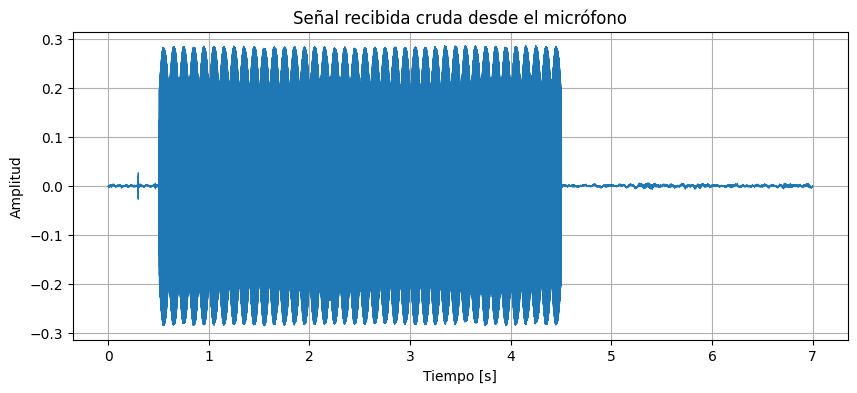

🔍 Buscando trama de inicio...


RuntimeError: No se detectó START (umbral muy alto o preámbulo no coincide).

In [75]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def norm_corr(x, h):
    """
    Correlación cruzada normalizada (NCC).
    Devuelve valores entre -1 y 1 aprox.
    """
    h = np.asarray(h)
    x = np.asarray(x)

    corr = signal.correlate(x, h, mode='valid')
    energia_x = np.sqrt(signal.convolve(x**2, np.ones(len(h)), mode='valid'))
    energia_h = np.sqrt(np.sum(h**2))
    ncc = corr / (energia_x * energia_h + 1e-12)
    return ncc

def detect_first_peak(ncc, thr=0.55, guard=200):
    """
    Detecta el PRIMER pico que supere umbral.
    guard: separa detecciones muy cercanas.
    """
    idxs = np.where(ncc > thr)[0]
    if len(idxs) == 0:
        return None, None

    # primer candidato
    first = idxs[0]

    # opcional: refinar al máximo local dentro de una pequeña ventana
    w0 = max(first-guard, 0)
    w1 = min(first+guard, len(ncc))
    local = np.argmax(ncc[w0:w1]) + w0
    return local, ncc[local]

def record_and_receive_8psk(
    Tb=0.005,
    fs=48000,
    fc=12000,
    beta=0.25,
    max_duration=10.0
):

    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    # Señal cruda tal cual la entregó el micrófono
    rx = recording[:, 0]

    # ===== 0. GRAFICAR SEÑAL CRUDA =====
    t_full = np.arange(len(rx)) / fs

    plt.figure(figsize=(10,4))
    plt.plot(t_full, rx, linewidth=0.8)
    plt.title("Señal recibida cruda desde el micrófono")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()

    # ===== 1. Generar START y END en 8-PSK =====
    t_start, s_start, _, _ = modulate_8psk(START_BITS, Tb, fs, fc, beta)
    t_end,   s_end,   _, _ = modulate_8psk(END_BITS,   Tb, fs, fc, beta)

    # Normalizaciones
    s_start = s_start / np.max(np.abs(s_start))
    s_end   = s_end   / np.max(np.abs(s_end))
    rx_norm = rx / (np.max(np.abs(rx)) + 1e-12)

   # ===== 2. Buscar inicio (NCC + primer pico) =====
    print("🔍 Buscando trama de inicio...")

    ncc_start = norm_corr(rx_norm, s_start)

    idx_start, peak_start = detect_first_peak(ncc_start, thr=0.55)
    if idx_start is None:
        raise RuntimeError("No se detectó START (umbral muy alto o preámbulo no coincide).")

    print(f"   Inicio detectado en muestra {idx_start} (ncc={peak_start:.4f})")
    print(f"   Inicio detectado en tiempo {idx_start/fs:.3f} s")

    start_sample = idx_start


    # ===== 3. Buscar fin =====
    print("🔍 Buscando trama de fin...")
    search_region = rx_norm[start_sample + len(s_start):]

    if len(search_region) < len(s_end):
        raise RuntimeError("Grabación demasiado corta para contener START + END.")

    ncc_end = norm_corr(search_region, s_end)

    idx_end_rel, peak_end = detect_first_peak(ncc_end, thr=0.55)
    if idx_end_rel is None:
        raise RuntimeError("No se detectó END (umbral muy alto o postámbulo no coincide).")

    end_sample = start_sample + len(s_start) + idx_end_rel

    print(f"   Fin detectado en muestra {end_sample} (ncc={peak_end:.4f})")
    print(f"   Fin detectado en tiempo {end_sample/fs:.3f} s")

    # ===== 4. Recortar =====
    msg_signal = rx[start_sample:end_sample + len(s_end)]
    t_msg = np.arange(len(msg_signal)) / fs

    print(f"📦 Mensaje recortado: {len(msg_signal)} muestras -> {len(msg_signal)/fs:.3f} s")

    # ===== 5. PLL =====
    phase_hist, phase_final = pll_track_phase(msg_signal, fs, fc)
    print(f"📐 Fase final estimada: {phase_final:.4f} rad")

    # ===== 6. Gráficos =====
    plt.figure(figsize=(10,6))

    plt.subplot(2,1,1)
    plt.plot(t_msg, msg_signal, linewidth=0.8)
    plt.title("Señal recortada entre START y END (8PSK)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t_msg, phase_hist)
    plt.title("Evolución de fase del PLL")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Fase [rad]")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return t_full, rx, t_msg, msg_signal, phase_hist, phase_final
START_BITS = "111001011001"   # preámbulo de inicio
END_BITS   = "000110100110"      # trama final
# Prueba de la función record_and_receive_8qam
t_full, rx, t_msg, msg_signal, phase_hist, phase_final = record_and_receive_8psk(
    Tb=0.1,
    fs=48000,
    fc=3000,
    beta=0.25,
    max_duration=7
)
# Demodulación del mensaje recibido
received_bits = demodulate_8psk(msg_signal, Tb=0.3, fs=48000, fc=2000, beta=0.25)
print("Bits recibidos: ", received_bits)